# Preprocessing Time Series Data

We will examine session 13 parquet file and see how preprocessing affects the data by examining the plots.

In [1]:
# import libs
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
import os

# import our own preprocessing function
from preprocess import ts_preprocess, rolling_average_onesided_hanning

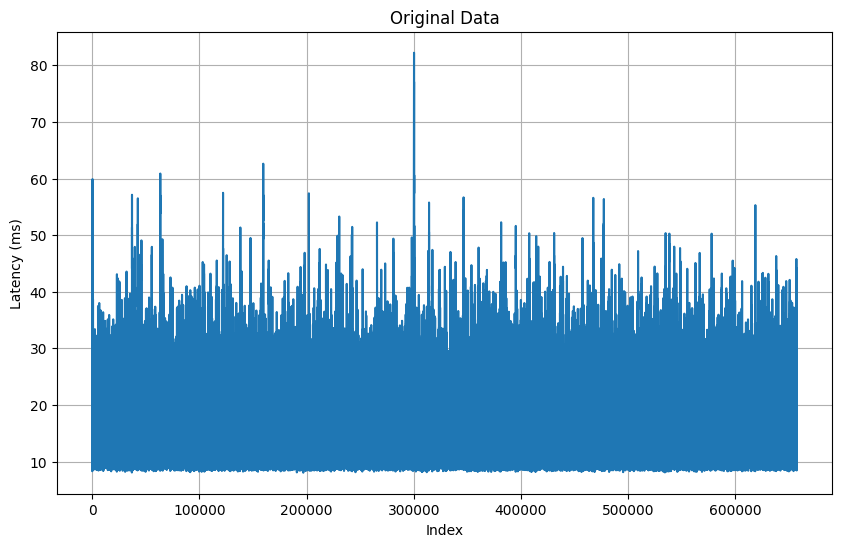

In [2]:
# Import the data (change filename to try processing other files)
pq_file_path = "/home/maximilian/Downloads/10-42-3-2_55500_20231113_134426.parquet"
pq_directory, pq_filename = os.path.split(pq_file_path)
df = pq.read_table(pq_file_path).to_pandas()

# Calculate wall latency (timestamps.client.send.wall - timestamps.server.receive.wall)
wall_latency = pd.Series(data=(df['timestamps.server.receive.wall'] - df['timestamps.client.send.wall'])/1e6, index=df.index)
# Calculate monotonic latency (timestamps.client.send.monotonic - timestamps.server.receive.monotonic)
#monotonic_latency = pd.Series(data=(df['timestamps.server.receive.monotonic'] - df['timestamps.client.send.monotonic'])/1e6, index=df.index)

plt.figure(figsize=(10, 6))
plt.plot(wall_latency)
plt.title('Original Data')
plt.xlabel('Index')
plt.ylabel('Latency (ms)')
plt.grid(True)
plt.show()

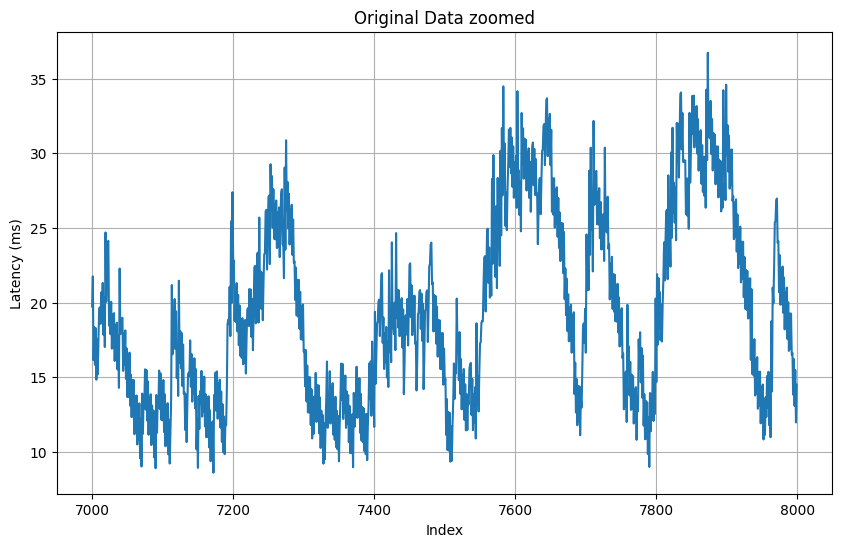

In [25]:
first_sample= 7000
last_sample = 8000

plt.figure(figsize=(10, 6))
plt.plot(wall_latency[first_sample:last_sample])
plt.title('Original Data zoomed')
plt.xlabel('Index')
plt.ylabel('Latency (ms)')
plt.grid(True)
plt.show()

### Rolling mean

In [8]:
window_length=15
rolling_average = rolling_average_onesided_hanning(wall_latency, window_length)

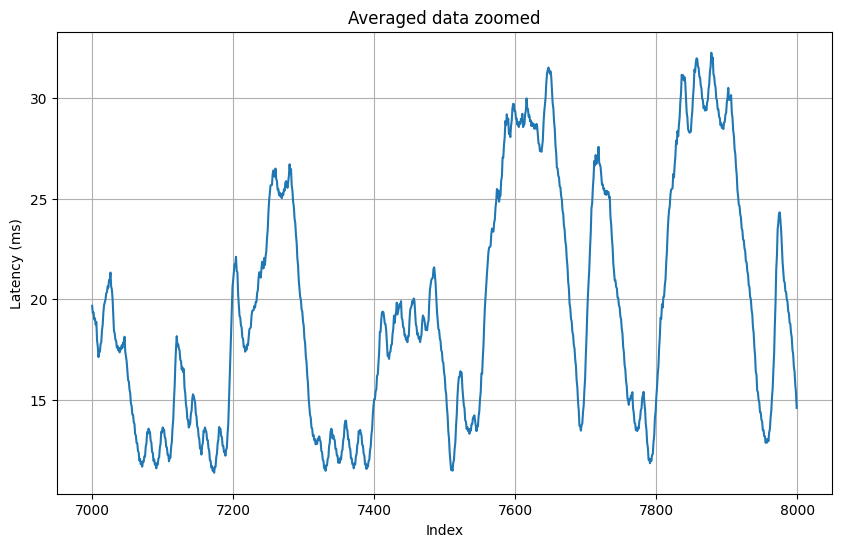

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(first_sample, last_sample), rolling_average[first_sample:last_sample])
plt.title('Averaged data zoomed')
plt.xlabel('Index')
plt.ylabel('Latency (ms)')
plt.grid(True)
plt.show()

In [123]:
csv_filename = os.path.splitext(pq_filename)[0] + "_moving_average_window_" + str(window_length) +".csv"
csv_file_path = os.path.join(pq_directory, csv_filename)

rolling_average.to_csv(csv_file_path)

### Subsampling

In [23]:
subsampling_rate = 5

window_length = max(subsampling_rate, 15)

rolling_average = rolling_average_onesided_hanning(wall_latency, window_length)

subsampled = rolling_average[0::subsampling_rate]

x_subsampled = [subsampling_rate * i for i in range(len(subsampled))]


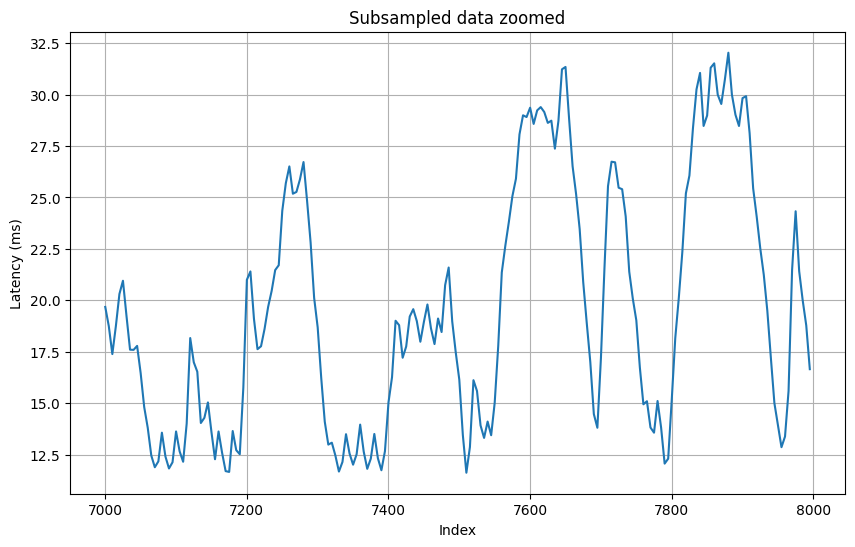

In [24]:
first_sample_subsampled = int(first_sample/subsampling_rate)
last_sample_subsampled = int(last_sample/subsampling_rate)

plt.figure(figsize=(10, 6))
plt.plot(x_subsampled[first_sample_subsampled:last_sample_subsampled], subsampled[first_sample_subsampled:last_sample_subsampled], label="subsampled")
plt.title('Subsampled data zoomed')
plt.xlabel('Index')
plt.ylabel('Latency (ms)')
plt.grid(True)
plt.show()

In [106]:
csv_filename = os.path.splitext(pq_filename)[0] + "_moving_subsampled_window_" + str(window_length) + "_rate_" + str(subsampling_rate) + ".csv"
csv_file_path = os.path.join(pq_directory, csv_filename)

subsampled.to_csv(csv_file_path)

### Plot averaged + subsampled

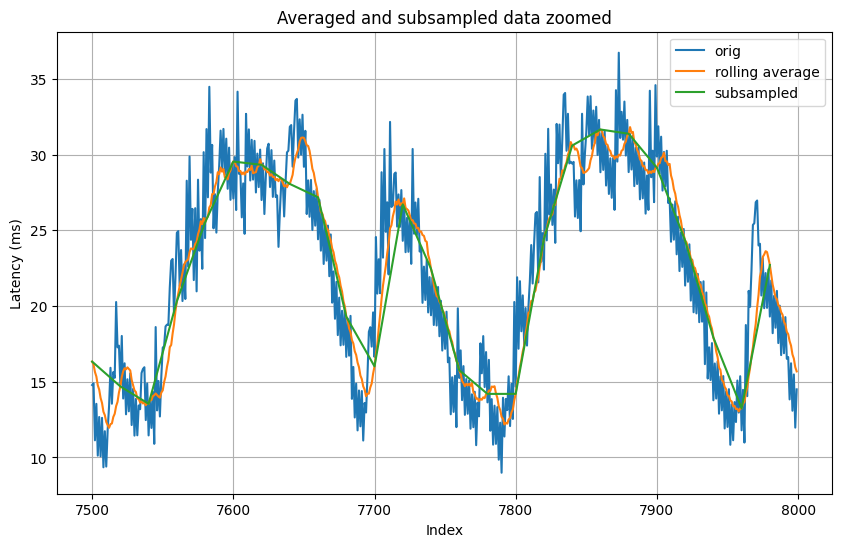

In [134]:
first_sample_subsampled = int(first_sample/subsampling_rate)
last_sample_subsampled = int(last_sample/subsampling_rate)

plt.figure(figsize=(10, 6))
plt.plot(wall_latency[first_sample:last_sample], label="orig")
plt.plot(range(first_sample, last_sample), rolling_average[first_sample:last_sample], label="rolling average")
plt.plot(x_subsampled[first_sample_subsampled:last_sample_subsampled], subsampled[first_sample_subsampled:last_sample_subsampled], label="subsampled")
plt.title('Averaged and subsampled data zoomed')
plt.xlabel('Index')
plt.ylabel('Latency (ms)')
plt.grid(True)
plt.legend()
plt.show()

### Data after denoising and removing outliers:

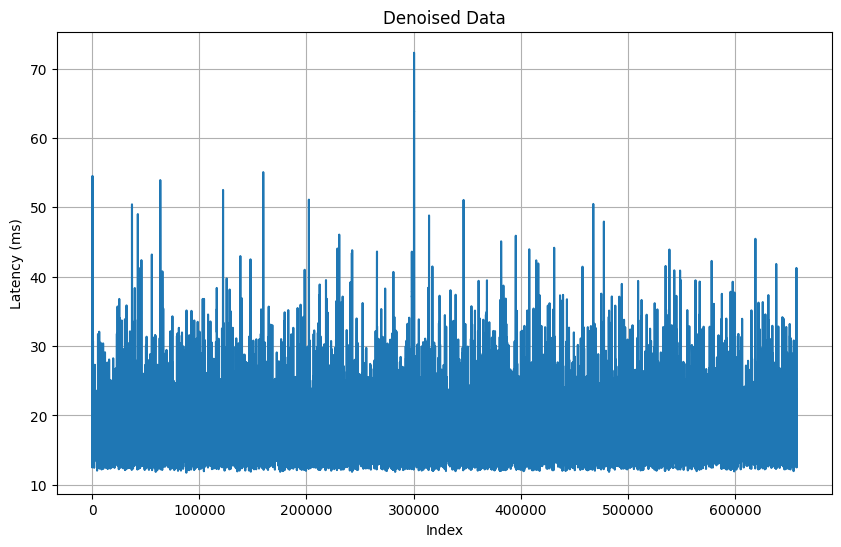

In [13]:
processed = ts_preprocess(wall_latency, window=50)

plt.figure(figsize=(10, 6))
plt.plot(processed)
plt.title('Denoised Data')
plt.xlabel('Index')
plt.ylabel('Latency (ms)')
plt.grid(True)
plt.show()

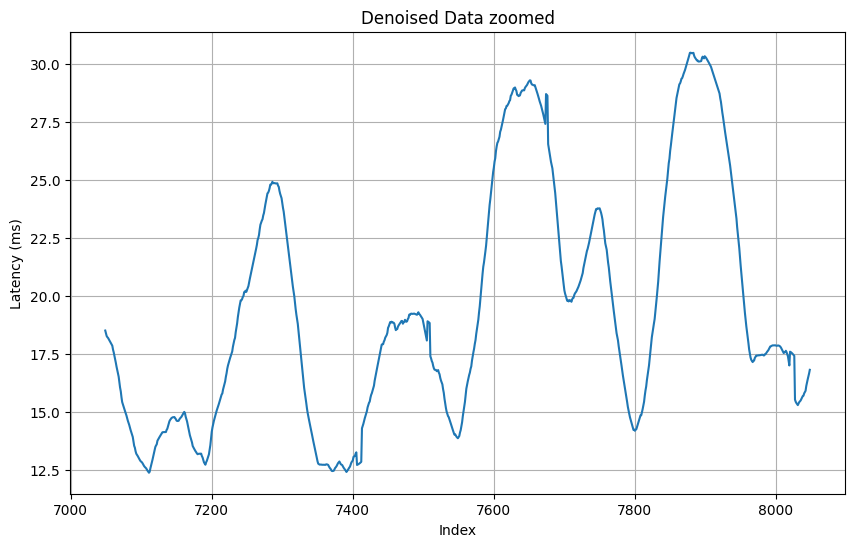

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(processed[first_sample:last_sample])
plt.title('Denoised Data zoomed')
plt.xlabel('Index')
plt.ylabel('Latency (ms)')
plt.grid(True)
plt.show()

### First-order difference for removing non-stationarity (recommended for traditional models):

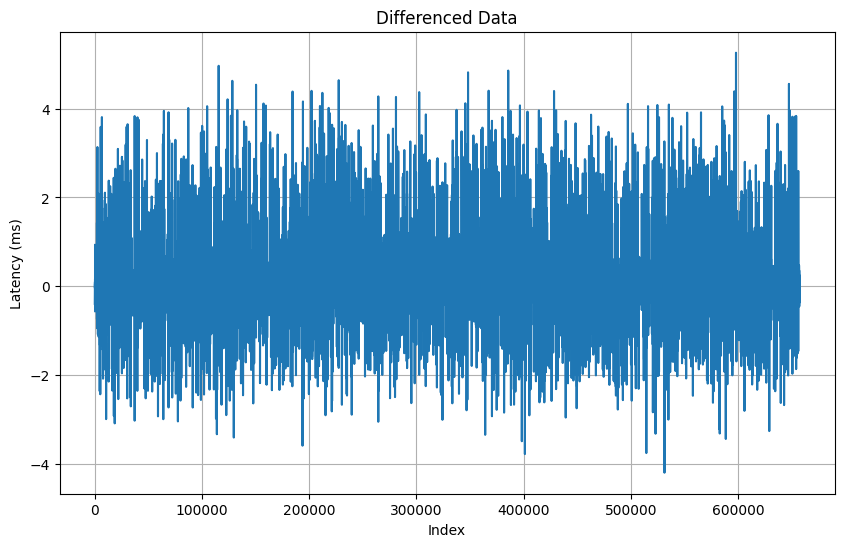

In [16]:
diff = ts_preprocess(wall_latency, window=50, diff=True)

plt.figure(figsize=(10, 6))
plt.plot(diff)
plt.title('Differenced Data')
plt.xlabel('Index')
plt.ylabel('Latency (ms)')
plt.grid(True)
plt.show()

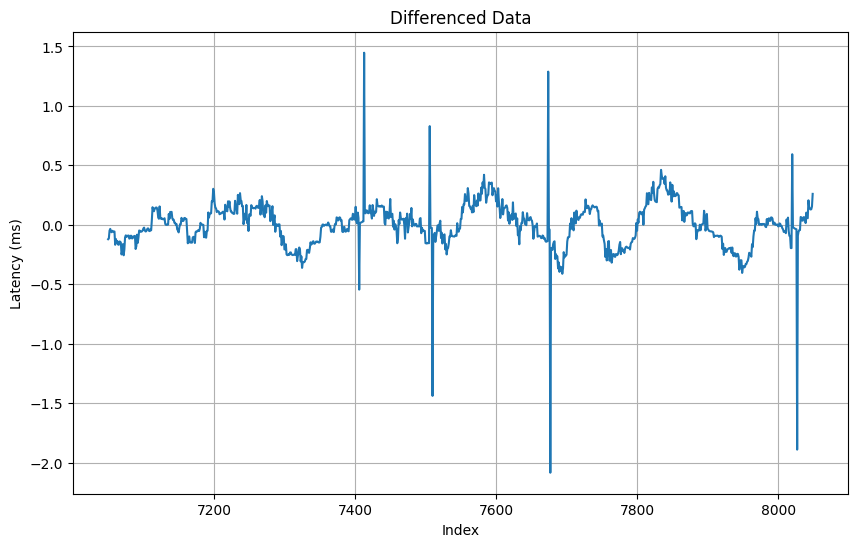

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(diff[first_sample:last_sample])
plt.title('Differenced Data')
plt.xlabel('Index')
plt.ylabel('Latency (ms)')
plt.grid(True)
plt.show()

### Normalization (can be used for Neural Networks):

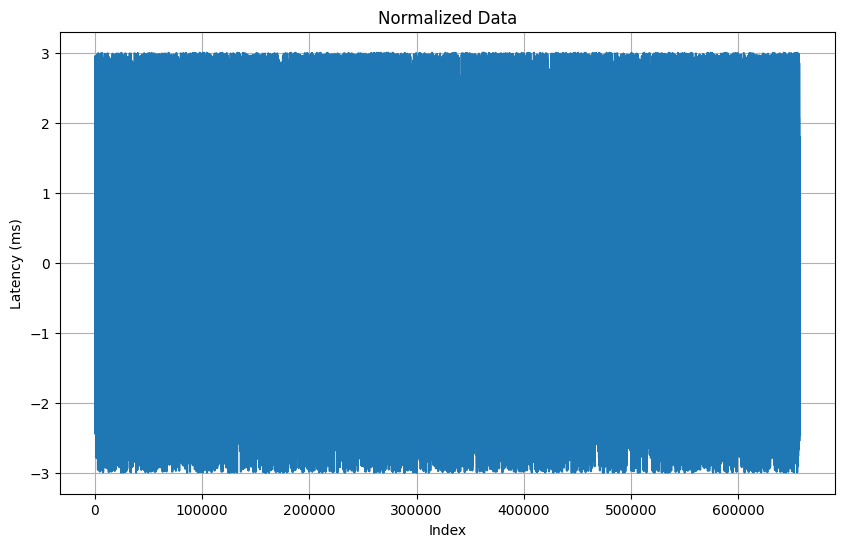

In [17]:
norm = ts_preprocess(wall_latency, window=50, normalize=True)

plt.figure(figsize=(10, 6))
plt.plot(norm)
plt.title('Normalized Data')
plt.xlabel('Index')
plt.ylabel('Latency (ms)')
plt.grid(True)
plt.show()

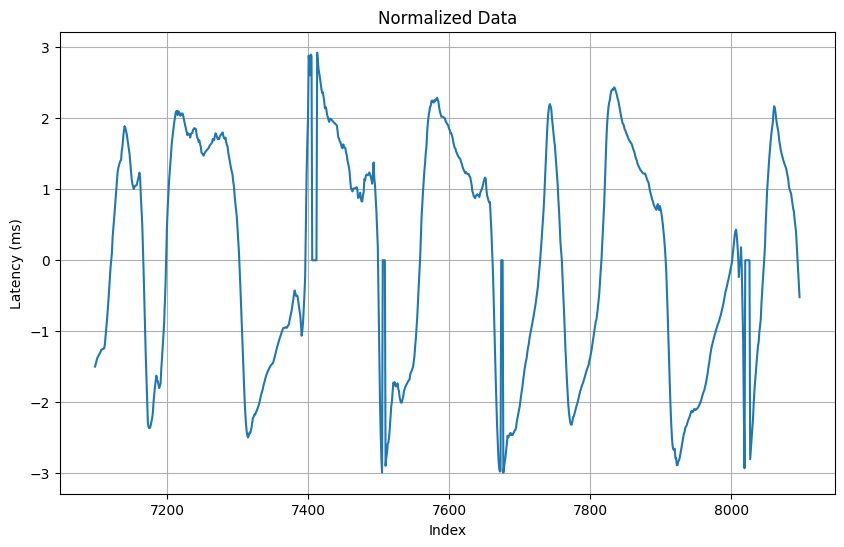

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(norm[first_sample:last_sample])
plt.title('Normalized Data')
plt.xlabel('Index')
plt.ylabel('Latency (ms)')
plt.grid(True)
plt.show()

### Difference and Normalization (not recommended):

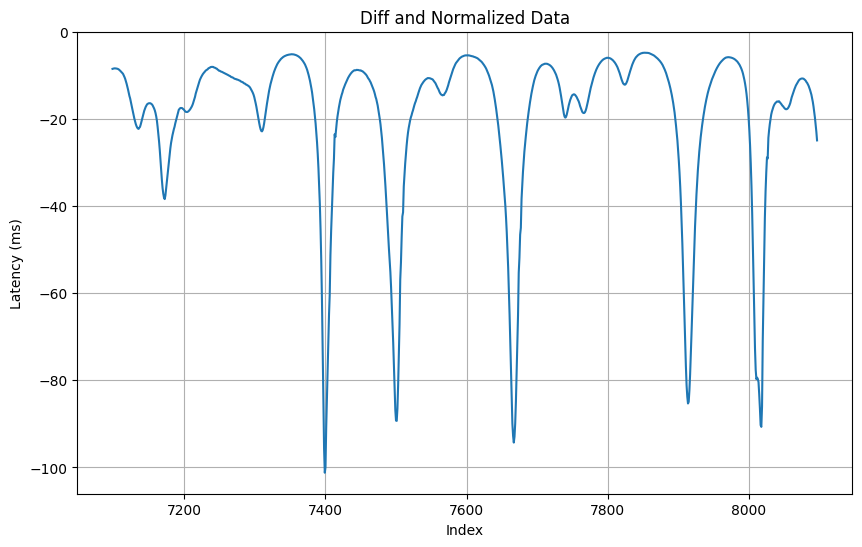

In [21]:
nd = ts_preprocess(wall_latency, window=50, diff=True, normalize=True)

plt.figure(figsize=(10, 6))
plt.plot(nd[first_sample:last_sample])
plt.title('Diff and Normalized Data')
plt.xlabel('Index')
plt.ylabel('Latency (ms)')
plt.grid(True)
plt.show()

### Write to CSV:

In [11]:
processed.to_csv('denoised.csv')
diff.to_csv('differenced.csv')
norm.to_csv('normalized.csv')